In [1]:
# Jupyter Notebook with widget matplotlib plots
# %matplotlib notebook
# Jupyter Lab with widget matplotlib plots
%matplotlib widget 
# with Jupyter and Jupyter Lab but without widget matplotlib plots
# %matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%time
import sys
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import pyicon as pyic
import cartopy.crs as ccrs
import glob, os
import xarray as xr
import pandas as pd
import cartopy
# import seawater as sw
import datetime

import multiprocessing
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
from dask.utils import format_bytes
from dask.distributed import Client, LocalCluster, progress # Libaray to orchestrate distributed resources

from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths

-----calc
sys glob os
numpy
netcdf
Done modules calc.
-----calc_xr
sys glob os
numpy
netcdf
xarray
Done modules calc.
-----tb
sys
json
numpy
scipy
netcdf datetime
matplotlib
mybreak
pnadas
xarray
done xarray
-----IconData
-----plotting
-----view
-----calc
-----calc_xr
-----tb
-----IconData
-----plotting
-----view
-----quickplots
-----quickplots
CPU times: user 1.83 s, sys: 1.9 s, total: 3.73 s
Wall time: 32.1 s


## Simulation details

In [3]:
run = 'ngSMT_tke'
path_scratch  = f'/scratch/u/u241317/dask_tmp/{run}/'
fpath_ckdtree = '/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/icon_ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.npz'

In [95]:
path_data = f'/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-03/{run}'

In [59]:
#### prep. dask cluster
search_str = f'_h_sp_*.nc' 
flist      = np.array(glob.glob(path_data+search_str))
flist.sort()

In [96]:
### Temperature
#### prep. dask cluster
search_str = f'_T_S_sp_001-016_*.nc' 
flist      = np.array(glob.glob(path_data+search_str))
flist.sort()

In [7]:
mfdset_kwargs = dict(combine='nested', concat_dim='flist', 
                     data_vars='minimal', coords='minimal', compat='override', join='override',
                     parallel=True,
                    )

## Load data

In [8]:
## Start cluster

!echo $HOSTNAME

mlogin104


In [9]:
# Set some user specific variables
account_name = 'mh0033' # Account that is going to be 'charged' fore the computation
queue = 'gpu' # Name of the partition we want to use
job_name = 'PostProc' # Job name that is submitted via sbatch
memory = "320GiB" # Max memory per node that is going to be used - this depends on the partition
cores = 24 # Max number of cores per task that are reserved - also partition dependend
walltime = '8:00:00' # Walltime - also partition dependent

In [10]:
scratch_dir = Path('/scratch') / getuser()[0] / getuser() # Define the users scratch dir
# Create a temp directory where the output of distributed cluster will be written to, after this notebook
# is closed the temp directory will be closed
dask_tmp_dir = TemporaryDirectory(dir=scratch_dir, prefix=job_name)
cluster = SLURMCluster(memory=memory,
                       cores=cores,
                       project=account_name,
                       walltime=walltime,
                       queue=queue,
                       name=job_name,
                       scheduler_options={'dashboard_address': ':8989'},
                       local_directory=dask_tmp_dir.name,
                       job_extra=[f'-J {job_name}', 
                                  f'-D {dask_tmp_dir.name}',
                                  f'--begin=now',
                                  f'--output={dask_tmp_dir.name}/LOG_cluster.%j.o',
                                  f'--output={dask_tmp_dir.name}/LOG_cluster.%j.o'
                                 ],
                       interface='ib0')

In [113]:
client.close()

cluster.close()

In [11]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p gpu
#SBATCH -A mh0033
#SBATCH -n 1
#SBATCH --cpus-per-task=24
#SBATCH --mem=320G
#SBATCH -t 8:00:00
#SBATCH -J PostProc
#SBATCH -D /scratch/u/u241317/PostProcwn_t88c1
#SBATCH --begin=now
#SBATCH --output=/scratch/u/u241317/PostProcwn_t88c1/LOG_cluster.%j.o
#SBATCH --output=/scratch/u/u241317/PostProcwn_t88c1/LOG_cluster.%j.o

/work/mh0033/u241317/miniconda3/envs/pyicon_py38/bin/python -m distributed.cli.dask_worker tcp://10.50.32.33:44688 --nthreads 4 --nprocs 6 --memory-limit 53.33GiB --name dummy-name --nanny --death-timeout 60 --local-directory /scratch/u/u241317/PostProcwn_t88c1 --interface ib0 --protocol tcp://



In [12]:
cluster.scale(jobs=2)
cluster

In [14]:
! squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          34249649       gpu PostProc  u241317  R       0:13      1 mg205
          34249650       gpu PostProc  u241317  R       0:13      1 mg207


In [15]:
client = Client(cluster)
client

<Client: 'tcp://10.50.32.33:44688' processes=0 threads=0, memory=0 B>

In [79]:
flist

array(['/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-01/ngSMT_tke_T_S_sp_001-016_20100109T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-01/ngSMT_tke_T_S_sp_001-016_20100110T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-01/ngSMT_tke_T_S_sp_001-016_20100111T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-01/ngSMT_tke_T_S_sp_001-016_20100112T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-01/ngSMT_tke_T_S_sp_001-016_20100113T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-01/ngSMT_tke_T_S_sp_001-016_20100114T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-01/ngSMT_tke_T_S_sp_001-016_20100115T010000Z.nc',
       '/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-01/ngSMT_tke_T_S_sp_001-016_20100116T010000Z.nc',
       '/mnt/lus

## Load data

In [17]:
fpath_tgrid  = '/home/mpim/m300602/work/icon/grids/smt/smt_tgrid.nc'
f = Dataset(fpath_tgrid, 'r')
clon = f.variables['clon'][:] * 180./np.pi # center longitude
clat = f.variables['clat'][:] * 180./np.pi # center latitude
f.close()

In [97]:
%%time
dh = xr.open_mfdataset(flist, combine='nested', concat_dim='time', parallel=True, chunks=dict(time=1)) # **mfdset_kwargs, **mfdset_kwargs
dh = dh.assign_coords({"clon": ("ncells", clon)})
dh = dh.assign_coords({"clat": ("ncells", clat)})

CPU times: user 1.01 s, sys: 30 ms, total: 1.04 s
Wall time: 1.2 s


In [98]:
#dh.h_sp
dh.S001_sp

<xarray.DataArray 'S001_sp' (time: 372, ncells: 59799625)>
dask.array<concatenate, shape=(372, 59799625), dtype=float32, chunksize=(1, 59799625), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 2.01e+07 2.01e+07 2.01e+07 ... 2.01e+07 2.01e+07
    clon     (ncells) float64 -54.21 -54.22 -54.22 ... -71.82 -71.8 -71.82
    clat     (ncells) float64 36.49 36.5 36.49 36.49 ... 9.447 9.437 9.447 9.453
Dimensions without coordinates: ncells
Attributes:
    standard_name:                salinity at level 001
    code:                         255
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

In [99]:
#h = dh.h_sp
#h = dh.T001_sp.T
h = dh.S001_sp

In [100]:
lon = [-64.8, -64.6]
lat = [39.6, 39.8]

In [101]:
#h = h.sel(clon=slice(lon[0],lon[1]), method="nearest")
#h = h.sel(clat=slice(40, 39), method="nearest")
h = h.where((h.clat > 39.6) & (h.clat < 39.8) & (h.clon > -64.8) & (h.clon < -64.6), drop=True)


In [38]:
#lon0, lat0 = -62.5, 41
#ic = np.argmin( (clon-lon0)**2 + (clat-lat0)**2 ) 

In [39]:
#h = h.isel(ncells=ic)
#h

In [102]:
#fpath = f'{path_scratch}/time_series_analysis_ssh_2d_1.nc'
fpath = f'{path_scratch}/time_series_analysis_S_2d_3.nc'
print(f'Saving file {fpath}')
h.to_netcdf(fpath)

Saving file /scratch/u/u241317/dask_tmp/ngSMT_tke//time_series_analysis_S_2d_3.nc


In [103]:
h

<xarray.DataArray 'S001_sp' (time: 372, ncells: 1198)>
dask.array<where, shape=(372, 1198), dtype=float32, chunksize=(1, 1198), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 2.01e+07 2.01e+07 2.01e+07 ... 2.01e+07 2.01e+07
    clon     (ncells) float64 -64.72 -64.73 -64.72 ... -64.71 -64.71 -64.7
    clat     (ncells) float64 39.69 39.68 39.69 39.69 ... 39.79 39.8 39.79 39.79
Dimensions without coordinates: ncells
Attributes:
    standard_name:                salinity at level 001
    code:                         255
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1

In [30]:
#lon = [-64.8, -64.6]
#lat = [39.6, 39.8]
#ind_reg = np.argmin( (clon-lon[0])**2 & (clon-lon[1])**2 & (clat-lat[0])**2 & (clat-lat[1])**2 )  

TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [50]:
path_data

'/scratch/u/u241317/dask_tmp/ngSMT_tke/'

In [104]:
#### prep. dask cluster
path_data = path_scratch
#search_str = f'time_series_analysis_ssh_2d_*.nc' 
search_str = f'time_series_analysis_S_*.nc' 
flist      = np.array(glob.glob(path_data+search_str))
flist.sort()

In [105]:
flist

array(['/scratch/u/u241317/dask_tmp/ngSMT_tke/time_series_analysis_S_2d_1.nc',
       '/scratch/u/u241317/dask_tmp/ngSMT_tke/time_series_analysis_S_2d_2.nc',
       '/scratch/u/u241317/dask_tmp/ngSMT_tke/time_series_analysis_S_2d_3.nc'],
      dtype='<U68')

In [106]:
dH = xr.open_mfdataset(flist, combine='nested', concat_dim='time', parallel=True, chunks=dict(time=1)) # **mfdset_kwargs, **mfdset_kwargs

In [107]:
#fpath = f'/work/mh0033/u241317/smt/time_series_analysis/time_series_analysis_ssh_2d.nc'
fpath = f'/work/mh0033/u241317/smt/time_series_analysis/time_series_analysis_S_2d.nc'
print(f'Saving file {fpath}')
dH.to_netcdf(fpath)

Saving file /work/mh0033/u241317/smt/time_series_analysis/time_series_analysis_S_2d.nc


In [108]:
tt = dH.isel(ncells=500)
tt

<xarray.Dataset>
Dimensions:  (time: 984)
Coordinates:
  * time     (time) float64 2.01e+07 2.01e+07 2.01e+07 ... 2.01e+07 2.01e+07
    clon     float64 dask.array<chunksize=(), meta=np.ndarray>
    clat     float64 dask.array<chunksize=(), meta=np.ndarray>
Data variables:
    S001_sp  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>

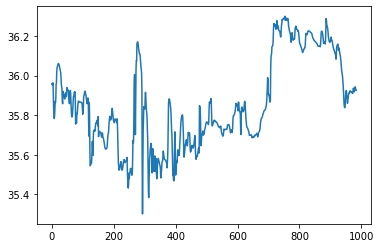

In [109]:
#fig, ax = plt
plt.plot(tt.S001_sp)
#plt.show()

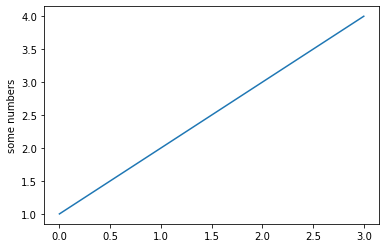

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot([1, 2, 3, 4])
plt.ylabel('some numbers')
plt.show()

In [107]:
import datetime
def convert_ts(ts):
    ymd, day_part = divmod(ts, 1)
    y, md = divmod(ymd, 10000)
    m, d = divmod(md, 100)
    day_part_secs = day_part * 86400
    return datetime.datetime(int(2000 + y), int(m), int(d)) + datetime.timedelta(seconds=day_part_secs)

In [108]:
tt = dH.time.data

In [111]:
tt

array([20100109.04166667, 20100109.125     , 20100109.20833333,
       20100109.29166667, 20100109.375     , 20100109.45833333,
       20100109.54166667, 20100109.625     , 20100109.70833333,
       20100109.79166667, 20100109.875     , 20100109.95833333,
       20100110.04166667, 20100110.125     , 20100110.20833333,
       20100110.29166667, 20100110.375     , 20100110.45833333,
       20100110.54166667, 20100110.625     , 20100110.70833333,
       20100110.79166667, 20100110.875     , 20100110.95833333,
       20100111.04166667, 20100111.125     , 20100111.20833333,
       20100111.29166667, 20100111.375     , 20100111.45833333,
       20100111.54166667, 20100111.625     , 20100111.70833333,
       20100111.79166667, 20100111.875     , 20100111.95833333,
       20100112.04166667, 20100112.125     , 20100112.20833333,
       20100112.29166667, 20100112.375     , 20100112.45833333,
       20100112.54166667, 20100112.625     , 20100112.70833333,
       20100112.79166667, 20100112.875  

In [110]:
a = convert_ts(tt)
a

TypeError: only size-1 arrays can be converted to Python scalars

In [104]:
a = pd.to_datetime(tt, format='%Y-%m-%d-%H') #format='%Y-%m-%d %H:%M:%S'

ValueError: time data '20100109' does not match format '%Y-%m-%d-%H' (match)

In [101]:
a

DatetimeIndex(['1970-01-01 00:00:00.020100109',
               '1970-01-01 00:00:00.020100109',
               '1970-01-01 00:00:00.020100109',
               '1970-01-01 00:00:00.020100109',
               '1970-01-01 00:00:00.020100109',
               '1970-01-01 00:00:00.020100109',
               '1970-01-01 00:00:00.020100109',
               '1970-01-01 00:00:00.020100109',
               '1970-01-01 00:00:00.020100109',
               '1970-01-01 00:00:00.020100109',
               ...
               '1970-01-01 00:00:00.020100331',
               '1970-01-01 00:00:00.020100331',
               '1970-01-01 00:00:00.020100331',
               '1970-01-01 00:00:00.020100331',
               '1970-01-01 00:00:00.020100331',
               '1970-01-01 00:00:00.020100331',
               '1970-01-01 00:00:00.020100331',
               '1970-01-01 00:00:00.020100331',
               '1970-01-01 00:00:00.020100331',
               '1970-01-01 00:00:00.020100331'],
              dtype=

In [84]:
from datetime import datetime

datetime.fromtimestamp(tt).strftime('%Y%m%d%h')

TypeError: only integer scalar arrays can be converted to a scalar index

In [15]:
time0      = np.datetime64('2010-03-15T21:00:00')
dti = pd.date_range(time0, periods=85, freq="2h")

In [16]:
dw = dw.assign_coords(time=dti)

In [17]:
mgroup

NameError: name 'mgroup' is not defined

### average

In [140]:
%%time 
# 
# fpatho = '/scratch/m/m300602/tmp/test_pp_dymwin_time_ave-Copy1.nc'
tslice = slice(0,20)   # for trials
dslice = slice(0,20)  # for trials
#tslice = slice(None, None)
#dslice = slice(None,None)
# vars_ave = ['kin']
vars_ave = ['w']

print('select vars')
# ds = xr.Dataset()
w = dw[vars_ave]
print('sel')
w = w.isel(time=tslice, depthi=dslice)

print('groupby')
mgroup = w.groupby('time.day').groups

print('Time ave')
for mm in mgroup:
    for var in vars_ave:
        #print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
        w_tave = w[var].isel(time=mgroup[mm]).mean(dim='time')
        fpath = f'{path_scratch}/examp_time_averaging_with_dask_{var}_{mm:02d}.nc'
        #w_tave = w_tave.compute()
        print(f'Saving file {fpath}')
        w_tave.to_netcdf(fpath)

print('All done!')

select vars
sel
groupby
Time ave
Saving file /scratch/u/u241317/dask_tmp/ngSMT_tke//examp_time_averaging_with_dask_w_15.nc
Saving file /scratch/u/u241317/dask_tmp/ngSMT_tke//examp_time_averaging_with_dask_w_16.nc
Saving file /scratch/u/u241317/dask_tmp/ngSMT_tke//examp_time_averaging_with_dask_w_17.nc
All done!
CPU times: user 41.8 s, sys: 2.26 s, total: 44.1 s
Wall time: 1min 44s


In [19]:
path_data = f'/work/mh0033/u241317/smt/db/pp_calc_b_period'
#### prep. dask cluster
search_str = f'_*.nc' 
flist      = np.array(glob.glob(path_data+search_str))
flist.sort()

In [20]:
%%time
db = xr.open_mfdataset(flist, combine='nested', concat_dim='None', parallel=True, chunks=dict(depthi=1)) # **mfdset_kwargs, **mfdset_kwargs
db = db.rename({'None': 'time'}) 
db = db.assign_coords(time=dti)

CPU times: user 1 s, sys: 65 ms, total: 1.07 s
Wall time: 1.24 s


In [22]:
dw

<xarray.Dataset>
Dimensions:  (depthi: 113, time: 85, cc: 59799625)
Coordinates:
  * depthi   (depthi) float32 0.0 5.0 8.0 11.0 ... 4.731e+03 5.22e+03 5.76e+03
  * time     (time) datetime64[ns] 2010-03-15T21:00:00 ... 2010-03-22T21:00:00
Dimensions without coordinates: cc
Data variables:
    w        (time, depthi, cc) float32 dask.array<chunksize=(1, 1, 59799625), meta=np.ndarray>

In [139]:
%%time 
# 
# fpatho = '/scratch/m/m300602/tmp/test_pp_dymwin_time_ave-Copy1.nc'
tslice = slice(0,20)   # for trials
dslice = slice(0,20)  # for trials
#tslice = slice(None, None)
#dslice = slice(None,None)
# vars_ave = ['kin']
vars_ave = ['b']

print('select vars')
# ds = xr.Dataset()
b = db[vars_ave]
print('sel')
b = b.isel(time=tslice, depthi=dslice)

print('groupby')
mgroup = b.groupby('time.day').groups

print('Time ave')
for mm in mgroup:
    for var in vars_ave:
        #print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
        b_tave = b[var].isel(time=mgroup[mm]).mean(dim='time')
        fpath = f'{path_scratch}/examp_time_averaging_with_dask_{var}_{mm:02d}.nc'
        #w_tave = w_tave.compute()
        print(f'Saving file {fpath}')
        b_tave.to_netcdf(fpath)

print('All done!')

select vars
sel
groupby
Time ave
Saving file /scratch/u/u241317/dask_tmp/ngSMT_tke//examp_time_averaging_with_dask_b_15.nc
Saving file /scratch/u/u241317/dask_tmp/ngSMT_tke//examp_time_averaging_with_dask_b_16.nc
Saving file /scratch/u/u241317/dask_tmp/ngSMT_tke//examp_time_averaging_with_dask_b_17.nc
All done!
CPU times: user 39 s, sys: 1.86 s, total: 40.9 s
Wall time: 1min 48s


#### calculate <b'w'> = <bw> - <b><w>

In [29]:
mgroup

{17: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 18: [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 19: [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 20: [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
 21: [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 22: [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]}

In [42]:
%%time 
# 
# fpatho = '/scratch/m/m300602/tmp/test_pp_dymwin_time_ave-Copy1.nc'
tslice = slice(14,85)   # for trials
dslice = slice(0,20)  # for trials
#tslice = slice(None, None)
#dslice = slice(None,None)

print('select vars')
# ds = xr.Dataset()
b = db['b']
print('sel')
b = b.isel(time=tslice, depthi=dslice)

w = dw['w']
print('sel')
w = w.isel(time=tslice, depthi=dslice)

print('groupby')
mgroup = b.groupby('time.day').groups

print('Time ave')
for mm in mgroup:
    wb = b.isel(time=mgroup[mm]) * w.isel(time=mgroup[mm])
    wb1 = wb.mean(dim='time') 
    b1 = b.isel(time=mgroup[mm]).mean(dim='time')
    w1 = w.isel(time=mgroup[mm]).mean(dim='time')
    wb_prime_tave = wb1 - b1*w1
    fpath = f'{path_scratch}/examp_time_averaging_with_dask_wb_prime_{mm:02d}.nc'
    print(f'Saving file {fpath}')
    wb_prime_tave.to_netcdf(fpath)

print('All done!')

select vars
sel
sel
groupby
Time ave
Saving file /scratch/u/u241317/dask_tmp/ngSMT_tke//examp_time_averaging_with_dask_wb_prime_17.nc


distributed.utils - ERROR - 'start'
Traceback (most recent call last):
  File "/work/mh0033/u241317/miniconda3/envs/pyicon_py38/lib/python3.8/site-packages/distributed/utils.py", line 650, in log_errors
    yield
  File "/work/mh0033/u241317/miniconda3/envs/pyicon_py38/lib/python3.8/site-packages/distributed/dashboard/components/shared.py", line 315, in update
    ts = metadata["keys"][self.key]
KeyError: 'start'
tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x2aedf80345e0>>, <Task finished name='Task-189481' coro=<_needs_document_lock.<locals>._needs_document_lock_wrapper() done, defined at /work/mh0033/u241317/miniconda3/envs/pyicon_py38/lib/python3.8/site-packages/bokeh/server/session.py:51> exception=KeyError('start')>)
Traceback (most recent call last):
  File "/work/mh0033/u241317/miniconda3/envs/pyicon_py38/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in 

Saving file /scratch/u/u241317/dask_tmp/ngSMT_tke//examp_time_averaging_with_dask_wb_prime_18.nc
Saving file /scratch/u/u241317/dask_tmp/ngSMT_tke//examp_time_averaging_with_dask_wb_prime_19.nc
Saving file /scratch/u/u241317/dask_tmp/ngSMT_tke//examp_time_averaging_with_dask_wb_prime_20.nc
Saving file /scratch/u/u241317/dask_tmp/ngSMT_tke//examp_time_averaging_with_dask_wb_prime_21.nc
Saving file /scratch/u/u241317/dask_tmp/ngSMT_tke//examp_time_averaging_with_dask_wb_prime_22.nc
All done!
CPU times: user 3min 50s, sys: 17.5 s, total: 4min 7s
Wall time: 13min 36s


In [27]:
mgroup

{17: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 18: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22],
 19: [23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34],
 20: [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46],
 21: [47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58],
 22: [59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]}

In [114]:
def calc_tave(mgroup, mm, var ):
    mean = var.isel(time=mgroup[mm]).mean(dim='time')
    return mean

In [118]:
print('Time ave')
for mm in mgroup:
    b_mean = calc_tave(mgroup, mm, b)
    w_mean = calc_tave(mgroup, mm, w)
    
    wb = b.isel(time=mgroup[mm]) * w.isel(time=mgroup[mm])
    wb_mean = calc_tave(mgroup, mm, wb)
    wb_prime_tave = wb_mean - b_mean * w_mean
    fpath = f'{path_scratch}/examp_time_averaging_with_dask_wb_prime_{mm:02d}.nc'
    print(f'Saving file {fpath}')
    wb_prime_tave.to_netcdf(fpath)

print('All done!')

Time ave
beam
Saving file /scratch/u/u241317/dask_tmp/ngSMT_tke//examp_time_averaging_with_dask_wb_prime_15.nc


KeyboardInterrupt: 

In [107]:
w = dw['w']
print('sel')
w = w.isel(time=tslice, depthi=dslice)

sel


In [109]:
wb = b.isel(time=mgroup[mm]) * w.isel(time=mgroup[mm])

In [111]:
wb.mean(dim='time') 

<xarray.DataArray (depthi: 20, cc: 59799625)>
dask.array<mean_agg-aggregate, shape=(20, 59799625), dtype=float32, chunksize=(1, 59799625), chunktype=numpy.ndarray>
Coordinates:
  * depthi   (depthi) float32 0.0 5.0 8.0 11.0 14.0 ... 47.0 50.0 53.0 56.0 59.0
Dimensions without coordinates: cc

In [43]:
path_data = f'/work/mh0033/u241317/smt/T/pp_calc_T_period'
#### prep. dask cluster
search_str = f'_*.nc' 
flist      = np.array(glob.glob(path_data+search_str))
flist.sort()

In [46]:
%%time
dT = xr.open_mfdataset(flist, combine='nested', concat_dim='None', parallel=True, chunks=dict(depthc=1)) # **mfdset_kwargs, **mfdset_kwargs
dT = dT.rename({'None': 'time'}) 
dT = dT.assign_coords(time=dti)

CPU times: user 1.19 s, sys: 58 ms, total: 1.25 s
Wall time: 1.38 s


In [58]:
%%time 
# 
# fpatho = '/scratch/m/m300602/tmp/test_pp_dymwin_time_ave-Copy1.nc'
tslice = slice(2,26)   # for trials
dslice = slice(0,20)  # for trials
#tslice = slice(None, None)
#dslice = slice(None,None)
# vars_ave = ['kin']
vars_ave = ['T']

print('select vars')
# ds = xr.Dataset()
T = dT[vars_ave]
print('sel')
T = T.isel(time=tslice, depthc=dslice)

print('groupby')
mgroup = T.groupby('time.day').groups

print('Time ave')
for mm in mgroup:
    for var in vars_ave:
        #print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
        T_tave = T[var].isel(time=mgroup[mm]).mean(dim='time')
        fpath = f'{path_scratch}/examp_time_averaging_with_dask_{var}_{mm:02d}.nc'
        #w_tave = w_tave.compute()
        print(f'Saving file {fpath}')
        T_tave.to_netcdf(fpath)

print('All done!')

select vars
sel
groupby
Time ave
Saving file /scratch/u/u241317/dask_tmp/ngSMT_tke//examp_time_averaging_with_dask_T_16.nc
Saving file /scratch/u/u241317/dask_tmp/ngSMT_tke//examp_time_averaging_with_dask_T_17.nc
All done!
CPU times: user 28 s, sys: 2.43 s, total: 30.4 s
Wall time: 1min 35s


In [59]:
##### calculate w'T'

In [72]:
%%time 
# 
# fpatho = '/scratch/m/m300602/tmp/test_pp_dymwin_time_ave-Copy1.nc'
tslice = slice(2,74)   # for trials
dslice = slice(0,20)  # for trials
#tslice = slice(None, None)
#dslice = slice(None,None)

print('select vars')
# ds = xr.Dataset()
T = dT['T']
print('sel')
T = T.isel(time=tslice, depthc=dslice)
T = T.rename({'depthc': 'depthi'}) 
T = T.rename({'temperature': 'cc'}) 

w = dw['w']
print('sel')
w = w.isel(time=tslice, depthi=dslice)

print('groupby')
mgroup = T.groupby('time.day').groups

print('Time ave')
for mm in mgroup:
    wT = T.isel(time=mgroup[mm]) * w.isel(time=mgroup[mm])
    wT1 = wT.mean(dim='time') 
    T1 = T.isel(time=mgroup[mm]).mean(dim='time')
    w1 = w.isel(time=mgroup[mm]).mean(dim='time')
    wT_prime_tave = wT1 - T1*w1
    fpath = f'{path_scratch}/examp_time_averaging_with_dask_wT_prime_{mm:02d}.nc'
    print(f'Saving file {fpath}')
    wT_prime_tave.to_netcdf(fpath)

print('All done!')

select vars
sel
sel
groupby
Time ave
Saving file /scratch/u/u241317/dask_tmp/ngSMT_tke//examp_time_averaging_with_dask_wT_prime_16.nc
Saving file /scratch/u/u241317/dask_tmp/ngSMT_tke//examp_time_averaging_with_dask_wT_prime_17.nc
Saving file /scratch/u/u241317/dask_tmp/ngSMT_tke//examp_time_averaging_with_dask_wT_prime_18.nc
Saving file /scratch/u/u241317/dask_tmp/ngSMT_tke//examp_time_averaging_with_dask_wT_prime_19.nc
Saving file /scratch/u/u241317/dask_tmp/ngSMT_tke//examp_time_averaging_with_dask_wT_prime_20.nc
Saving file /scratch/u/u241317/dask_tmp/ngSMT_tke//examp_time_averaging_with_dask_wT_prime_21.nc
All done!
CPU times: user 3min 48s, sys: 18.1 s, total: 4min 6s
Wall time: 12min 59s


In [63]:
mgroup

{16: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 17: [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 18: [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 19: [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
 20: [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 21: [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]}

In [74]:
wT = T.isel(time=mgroup[mm]) * w.isel(time=mgroup[mm])

In [75]:
wT

<xarray.DataArray (time: 12, depthi: 20, cc: 59799625)>
dask.array<mul, shape=(12, 20, 59799625), dtype=float32, chunksize=(1, 1, 59799625), chunktype=numpy.ndarray>
Coordinates:
  * depthi   (depthi) float32 0.0 5.0 8.0 11.0 14.0 ... 47.0 50.0 53.0 56.0 59.0
  * time     (time) datetime64[ns] 2010-03-21T01:00:00 ... 2010-03-21T23:00:00
Dimensions without coordinates: cc